# Transfer Learning: **Feature Extraction**

Transfer Learning is the reuse of a **Pre-Trained Model/s** on a second related task to *save computational time and data acquisition cost* (as Deep Learning Models are Data Hungry and Acquiring that much **Labelled
Data** is a tedious task).

**Note** : Transfer learning is particularly useful when you have a small dataset for the new task because it allows you to benefit from the knowledge learned by a model trained on a large dataset for a similar task.



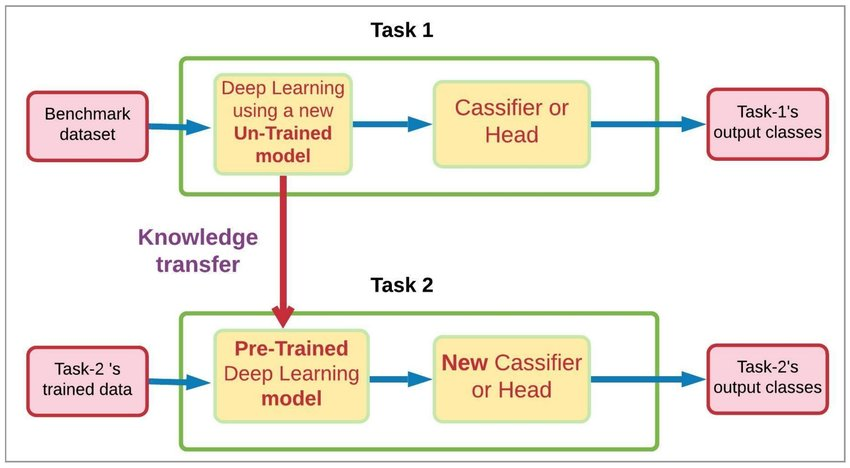

## How Transfer Learning Works?


* **Pretrained Model**: Start with a pretrained model that has been trained on a large dataset for a specific task, such as image classification or natural language processing. The pretrained model has learned to extract useful features from the input data relevant to the original task.

* **Feature Extraction**: Freeze the weights of the pretrained model's early layers, which are responsible for learning generic features like edges in images or word embeddings in text. These layers are typically called the base layers. Then, remove the original output layer(s) of the pretrained model.
* **Custom Head**: Add new layers on top of the base layers to serve as the output layers for the new task. These new layers, often called the head or the classifier, are typically shallow layers that are specific to the new task. The weights of these layers are randomly initialized or initialized using transfer learning techniques.
* **Training**: Train the entire model, including both the base layers (with frozen weights) and the new head layers, on the new dataset. During training, the weights of the new head layers are updated to adapt the model to the new task, while the weights of the base layers remain fixed.
* **Fine-Tuning (Optional)**: After training with the frozen base layers, you can optionally unfreeze some or all of the base layers and continue training the entire model on the new dataset. This step, known as fine-tuning, allows the model to further adapt its feature representations to the new task by adjusting the weights of both the base and head layers.

Here, I'll be using **VGGNET-16 Pre-Trained Model** for our model building.


VGGNet, short for Visual Geometry Group Network, is a convolutional neural network architecture proposed by the Visual Geometry Group at the University of Oxford.

VGGNet is known for its simplicity and uniform architecture, consisting of several convolutional layers followed by max-pooling layers, with fully connected layers at the end.

VGGNet achieved excellent performance on the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2014.

## VGGNet-16 Architecture


1. **Input Layer**: Accepts input images of fixed size (e.g., 224x224 pixels).
2. **Convolutional Blocks**: Consist of multiple convolutional layers followed by max-pooling layers. The number of filters increases with the depth of the network.
3. **Fully Connected Layers**: Flatten the output of the convolutional layers and pass it through fully connected layers to perform classification.
4. **Output Layer**: Produces the final classification probabilities using a softmax activation function.

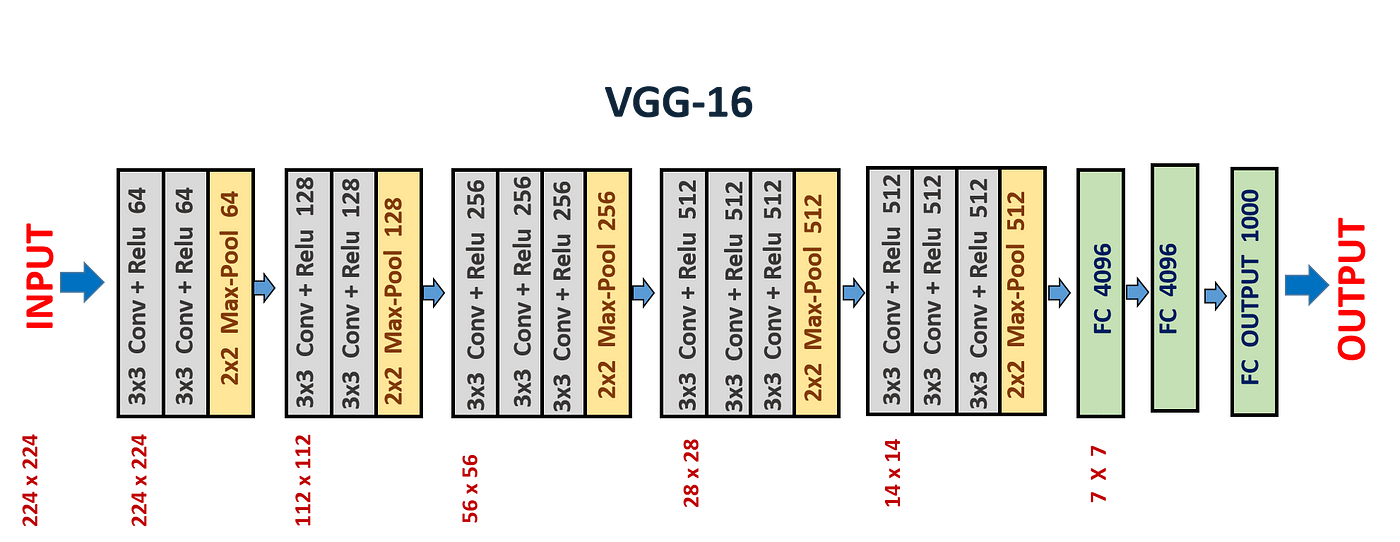

This table will help you understand VGGNET-16 Architecture.

VGG16 has 16 layers, including 13 convolutional layers and 3 fully connected layers. The convolutional layers use 3x3 filters with a stride of 1 and padding to maintain the spatial dimensions of the input. Max-pooling layers with 2x2 filters and a stride of 2 are used to downsample the feature maps.

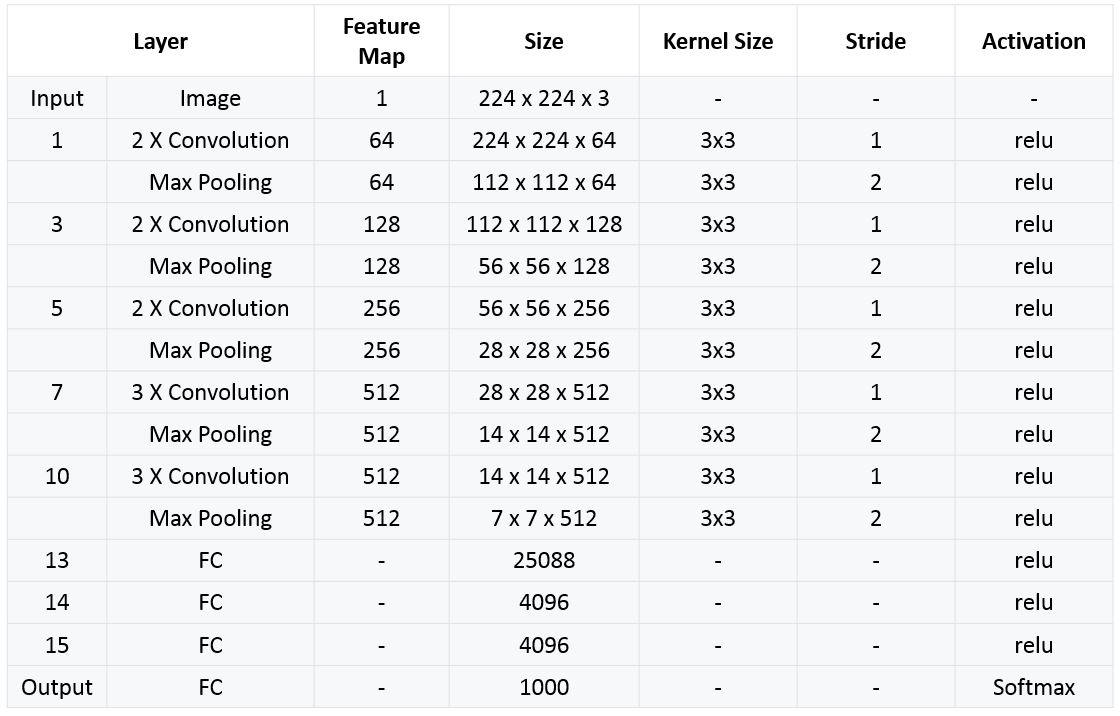

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

 98% 1.04G/1.06G [00:04<00:00, 286MB/s]
100% 1.06G/1.06G [00:04<00:00, 264MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from keras.applications.vgg16 import VGG16

## VGGNET Convolutional Layers

In [ ]:
conv_base = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (150,150,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()

model.add(conv_base)

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Freezing the Convo-Layers

In [ ]:
conv_base.trainable = False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


## Generators

To batch wise upload data to system.

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


## Normalize

The images are stored in numpy array format (0-255), to which we need to normalize btw (0-1).

In [ ]:
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 214s 341ms/step - loss: 0.2803 - accuracy: 0.8798 - val_loss: 0.2243 - val_accuracy: 0.9046
Epoch 2/10
625/625 [==============================] - 211s 337ms/step - loss: 0.1945 - accuracy: 0.9195 - val_loss: 0.2050 - val_accuracy: 0.9118
Epoch 3/10
625/625 [==============================] - 211s 337ms/step - loss: 0.1662 - accuracy: 0.9332 - val_loss: 0.2596 - val_accuracy: 0.8990
Epoch 4/10
625/625 [==============================] - 213s 340ms/step - loss: 0.1465 - accuracy: 0.9406 - val_loss: 0.2081 - val_accuracy: 0.9186
Epoch 5/10
625/625 [==============================] - 215s 343ms/step - loss: 0.1172 - accuracy: 0.9530 - val_loss: 0.2271 - val_accuracy: 0.9154
Epoch 6/10
625/625 [==============================] - 212s 338ms/step - loss: 0.1069 - accuracy: 0.9589 - val_loss: 0.2416 - val_accuracy: 0.9182
Epoch 7/10
625/625 [==============================] - 216s 346ms/step - loss: 0.0805 - accuracy: 0.9690 - val_loss: 0.2497 -

Upon reviewing our previous CNN model, it's evident that the validation accuracy has substantially improved from 79% to 90.80% with the implementation of transfer learning.

Upon careful analysis, it's noted that while the training accuracy has increased marginally from 97% to 98.21%, the validation accuracy reaching 90.80% may indicate overfitting within the system.

Let's plot graphs to validate this observation!

In [ ]:
import matplotlib.pyplot as plt

## Train VS Validation Accuracy





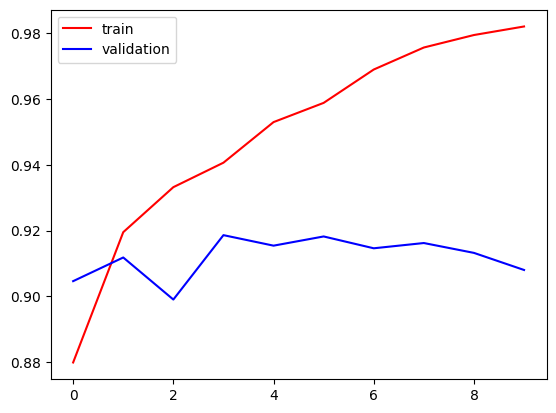

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

## Train VS Validation Loss

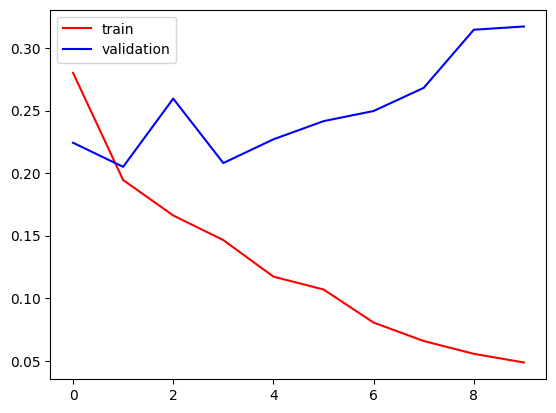

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

Clearly, overfitting is seen in the model.

Want to upgrade your model?

Checkout, Part: 2 of [Transfer Learning-Feature Extraction With Augumentation!](https://github.com/nikitaprasad21/DL-Cheat-Codes/blob/main/CNN-Models/transfer_learning_feature_extraction_data_augmentation.ipynb)

This follow-up segment focuses on further improving your model's performance through feature extraction with augmentation techniques.

> Don't forget to **Star** this Repo and share with your friends!